In [ ]:
//@version=5
indicator("Exact 30m Panel on Any TF (Closed + LIVE 30m Candle)", overlay=true, max_labels_count=500, max_boxes_count=500, max_lines_count=500)

// ---- SETTINGS ----
len    = input.int(30, "Number of CLOSED 30m candles", minval=1)
offset = input.int(5, "Offset from right edge (bars)")
spacing = 3    // horizontal footprint per 30m candle (2 body + 1 gap)

// ---- COLOR SETTINGS ----
bullColor = input.color(color.new(color.green, 0), "Bull Candle Color")
bearColor = input.color(color.new(color.red, 0), "Bear Candle Color")
wickColor = input.color(color.black, "Wick Color")
borderCol = color.black 

// ---- GET 30m CLOSED series ----   
[o30, h30, l30, c30] = request.security(syminfo.tickerid, "30", [open, high, low, close], barmerge.gaps_on)

// ---- detect 30m boundary ----
isNew30Boundary = ta.change(time("30"))

// ---- Buffers for closed candles ----
var float[] bufO = array.new_float(len, na)
var float[] bufH = array.new_float(len, na)
var float[] bufL = array.new_float(len, na)
var float[] bufC = array.new_float(len, na)

// Maintain buffer if len changed
if array.size(bufO) != len
    bufO := array.new_float(len, na)
    bufH := array.new_float(len, na)
    bufL := array.new_float(len, na)
    bufC := array.new_float(len, na)

// ---- Store CLOSED 30m candle on new boundary ----
if isNew30Boundary
    closedO = o30[1]
    closedH = h30[1]
    closedL = l30[1]
    closedC = c30[1]

    if not na(closedO) and not na(closedC)
        array.unshift(bufO, closedO)
        array.unshift(bufH, closedH)
        array.unshift(bufL, closedL)
        array.unshift(bufC, closedC)

        if array.size(bufO) > len
            array.pop(bufO)
            array.pop(bufH)
            array.pop(bufL)
            array.pop(bufC)

// ---- Historical Prefill ----
var bool didPrefill = false
if not didPrefill
    maxScanBars = 2000
    var float[] tO = array.new_float()
    var float[] tH = array.new_float()
    var float[] tL = array.new_float()
    var float[] tC = array.new_float()

    for i = 1 to maxScanBars
        if bar_index - i < 0
            break
        if time("30")[i] != time("30")[i+1]
            co = o30[i+1]
            ch = h30[i+1]
            cl = l30[i+1]
            cc = c30[i+1]
            if not na(co) and not na(cc)
                array.push(tO, co)
                array.push(tH, ch)
                array.push(tL, cl)
                array.push(tC, cc)
        if array.size(tO) >= len
            break

    if array.size(tO) > 0
        bufO := array.new_float()
        bufH := array.new_float()
        bufL := array.new_float()
        bufC := array.new_float()
        for j = array.size(tO) - 1 to 0 by -1
            array.push(bufO, array.get(tO, j))
            array.push(bufH, array.get(tH, j))
            array.push(bufL, array.get(tL, j))
            array.push(bufC, array.get(tC, j))
        while array.size(bufO) < len
            array.push(bufO, na)
            array.push(bufH, na)
            array.push(bufL, na)
            array.push(bufC, na)
    didPrefill := true

// ---- LIVE 30m candle on lower TF (manual accumulation) ----
tf_sec = 30 * 60  // 30 minutes in seconds
curr30_open_time = math.floor(time / 1000 / tf_sec) * tf_sec * 1000  // start time of current 30m candle in ms

var float liveO = na
var float liveH = na
var float liveL = na
var float liveC = na

if na(liveO) or time == curr30_open_time
    liveO := open
    liveH := high
    liveL := low

liveH := math.max(liveH, high)
liveL := math.min(liveL, low)
liveC := close

// ---- DRAW ----
var box[] bodies = array.new_box()
var line[] wicks = array.new_line()

if barstate.isfirst
    // +1 slot for LIVE candle
    for i = 0 to len
        array.push(bodies, na)
        array.push(wicks, na)

// ---- RENDER ----
anchor = bar_index
for i = 0 to len
    _o = i == 0 ? liveO : array.get(bufO, i - 1)
    _h = i == 0 ? liveH : array.get(bufH, i - 1)
    _l = i == 0 ? liveL : array.get(bufL, i - 1)
    _c = i == 0 ? liveC : array.get(bufC, i - 1)

    if na(_o) or na(_c)
        continue

    hi = math.max(_o, _c)
    lo = math.min(_o, _c)

    xL = anchor + offset + (len - i + 1) * spacing
    xR = xL + 2
    xM = xL + 1

    _bg = _c >= _o ? bullColor : bearColor

    // body
    body = array.get(bodies, i)
    if na(body)
        body := box.new(xL, hi, xR, lo, border_color=borderCol, bgcolor=_bg)
        array.set(bodies, i, body)
    else
        box.set_left(body, xL)
        box.set_right(body, xR)
        box.set_top(body, hi)
        box.set_bottom(body, lo)
        box.set_bgcolor(body, _bg)

    // wick
    wick = array.get(wicks, i)
    if na(wick)
        wick := line.new(xM, _h, xM, _l, width=1, color=wickColor)
        array.set(wicks, i, wick)
    else
        line.set_x1(wick, xM)
        line.set_x2(wick, xM)
        line.set_y1(wick, _h)
        line.set_y2(wick, _l)



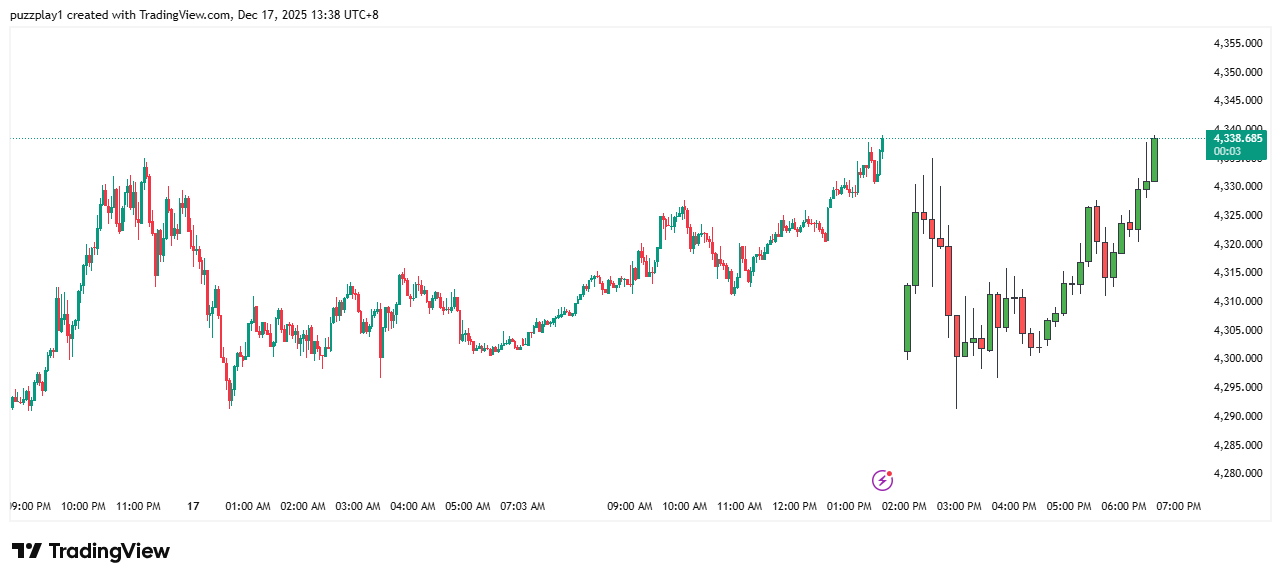